In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
import random

from scipy import stats as sc
from scipy.stats import lognorm, norm

from sklearn.model_selection import train_test_split

from colorama import Fore, Style
from termcolor import colored
import matplotlib.pyplot as plt
from collections import Counter


from UQpy import surrogates, sensitivity, distributions
from UQpy.surrogates import PolynomialChaosExpansion, TotalDegreeBasis
from UQpy.sensitivity import PceSensitivity
from UQpy.distributions import Uniform, Normal, Lognormal, JointIndependent
from UQpy.surrogates.polynomial_chaos.polynomials.baseclass.Polynomials import Polynomials
from UQpy.surrogates.polynomial_chaos.regressions.LeastSquareRegression import LeastSquareRegression

In [3]:
#Nastaveni kodu
nsim=200 #Pocet simulci se kterimi PCE pracuje
target_error = 1
CheckOverfitting = True
least_squares = LeastSquareRegression()

In [7]:
# Načtení dat
df = pd.read_csv('Oakwood(3).csv')
df.head()
print(df.shape)
df_split = df.iloc[:, 0].str.split(";", expand=True)
input_names = [
    "Ec", "Rel", "Erat_1", "E50_1", "c_1", "phi_1", "k0_1",
    "Erat_2", "E50_2", "c_2", "phi_2", "k0_2"
]
output_names = [
    "U_251_1", "U_260_1", "U_281_1", "U_289_1", "U_295_1", "U_403_1",
    "U_251_2", "U_260_2", "U_281_2", "U_289_2", "U_295_2", "U_403_2",
    "U_320_19.2", "U_318_19.2", "U_316_19.2", "U_315_19.2", "U_314_19.2",
    "U_313_19.2", "U_312_19.2", "U_311_19.2", "U_310_19.2", "U_308_19.2", "U_306_19.2"
]
all_names = input_names + output_names
df_split.columns = all_names
df_float = df_split.astype(float)


(1000, 1)


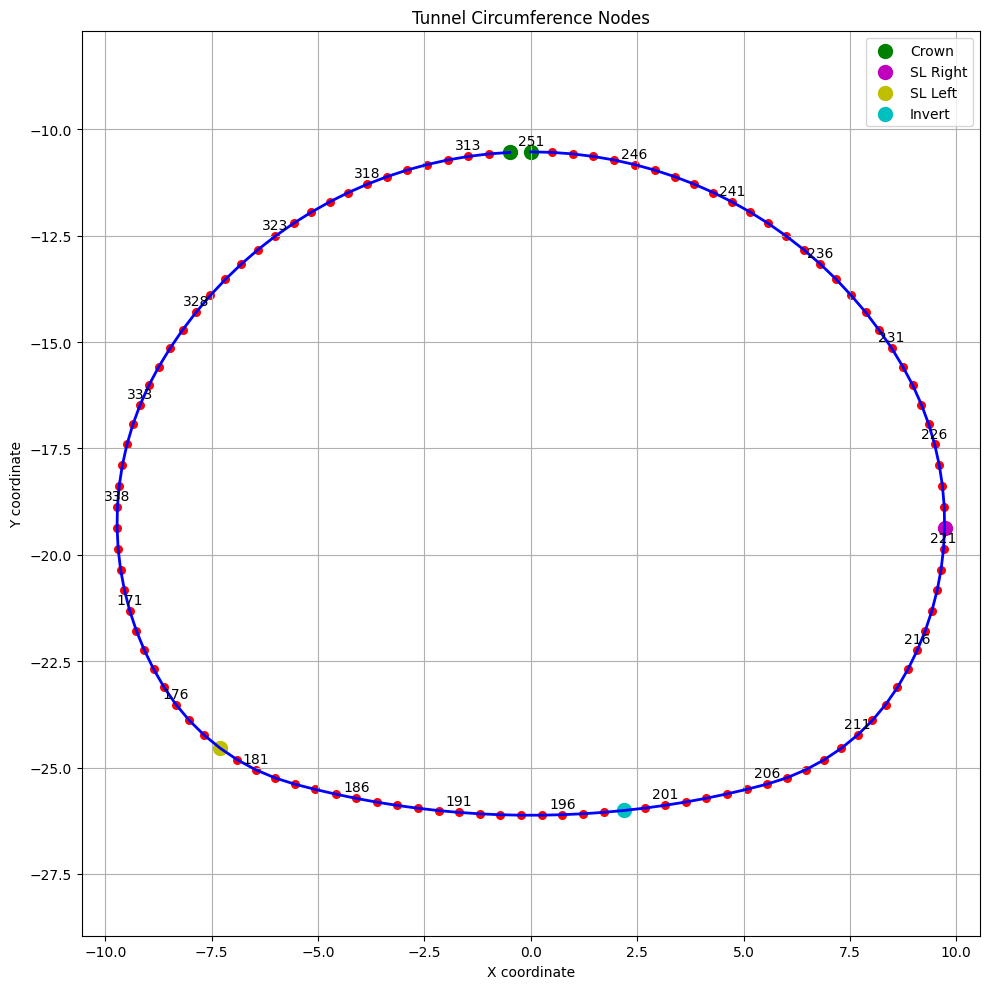

In [9]:
#Vykresleni tvaru uzlu
nodes = [
    (0, -10.5275), (0.492, -10.5395), (0.983, -10.5755), (1.4719, -10.6353),
    (1.95708, -10.719), (2.43761, -10.8261), (2.91235, -10.9566), (3.38016, -11.1101),
    (3.83994, -11.2861), (4.29059, -11.4844), (4.73104, -11.7044), (5.16024, -11.9456),
    (5.57717, -12.2075), (6.00215, -12.505), (6.41129, -12.824), (6.80351, -13.1636),
    (7.17776, -13.5229), (7.53, -13.901), (7.87, -14.2968), (8.18, -14.7093),
    (8.48, -15.1374), (8.74685, -15.58), (8.97931, -16.0164), (9.18182, -16.4675),
    (9.35346, -16.9312), (9.49344, -17.4055), (9.60113, -17.8881), (9.67604, -18.3768),
    (9.71783, -18.8695), (9.7263, -19.3639), (9.70142, -19.8578), (9.64331, -20.3488),
    (9.55222, -20.8348), (9.42857, -21.3136), (9.27246, -21.7842), (9.08488, -22.2431),
    (8.86671, -22.6884), (8.61894, -23.1179), (8.34143, -23.5199), (8.02741, -23.8942),
    (7.67966, -24.2374), (7.30124, -24.5464), (6.89548, -24.8185), (6.46599, -25.0513),
    (6.01653, -25.2428), (5.55109, -25.3913), (5.07787, -25.5123), (4.60202, -25.6225),
    (4.12377, -25.7219), (3.6434, -25.8104), (3.16338, -25.8875), (2.68174, -25.9538),
    (2.19873, -26.0091), (1.71458, -26.0534), (1.22955, -26.0868), (0.744, -26.1092),
    (0.258, -26.1205), (-0.228, -26.1209), (-0.714, -26.1102), (-1.20007, -26.0885),
    (-1.68514, -26.0558), (-2.16935, -26.0121), (-2.65244, -25.9574), (-3.13417, -25.8919),
    (-3.61429, -25.8154), (-4.10204, -25.7262), (-4.58759, -25.6257), (-5.07, -25.5141),
    (-5.55, -25.3913), (-6.01653, -25.2428), (-6.47, -25.0513), (-6.90, -24.8185),
    (-7.30124, -24.5464), (-7.67966, -24.2374), (-8.02741, -23.8942), (-8.34143, -23.5199),
    (-8.61894, -23.1179), (-8.86671, -22.6884), (-9.08488, -22.2431), (-9.27246, -21.7842),
    (-9.42857, -21.3136), (-9.55222, -20.8348), (-9.64331, -20.3488), (-9.70142, -19.8578),
    (-9.7263, -19.3639), (-9.71783, -18.8695), (-9.67604, -18.3768), (-9.60113, -17.8881),
    (-9.49344, -17.4055), (-9.35346, -16.9312), (-9.18182, -16.4675), (-8.97931, -16.0164),
    (-8.74685, -15.58), (-8.47618, -15.1374), (-8.18314, -14.7093), (-7.86849, -14.2968),
    (-7.53307, -13.901), (-7.17776, -13.5229), (-6.80351, -13.1636), (-6.41129, -12.824),
    (-6.00215, -12.505), (-5.57717, -12.2075), (-5.16024, -11.9456), (-4.73104, -11.7044),
    (-4.29059, -11.4844), (-3.83994, -11.2861), (-3.38016, -11.1101), (-2.91235, -10.9566),
    (-2.43761, -10.8261), (-1.95708, -10.719), (-1.4719, -10.6353), (-0.983, -10.5755),
    (-0.492, -10.5395)
]

x = [point[0] for point in nodes]
y = [point[1] for point in nodes]
plt.figure(figsize=(10, 10))
plt.plot(x, y, 'b-', linewidth=2)  # Connect all points with a blue line
plt.scatter(x, y, c='r', s=30)   

# Hspecial points
crown_nodes = [nodes[0], nodes[-1]]
sl_right = nodes[29]
sl_left = nodes[72]
invert = nodes[52]
plt.scatter([p[0] for p in crown_nodes], [p[1] for p in crown_nodes], c='g', s=100, label='Crown')
plt.scatter(sl_right[0], sl_right[1], c='m', s=100, label='SL Right')
plt.scatter(sl_left[0], sl_left[1], c='y', s=100, label='SL Left')
plt.scatter(invert[0], invert[1], c='c', s=100, label='Invert')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Tunnel Circumference Nodes')
plt.grid(True)
plt.axis('equal') 
plt.legend()
for i, (xi, yi) in enumerate(nodes):
    if i % 5 == 0: 
        plt.annotate(str(251-i if i <= 83 else 251-i+172), (xi, yi), textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()

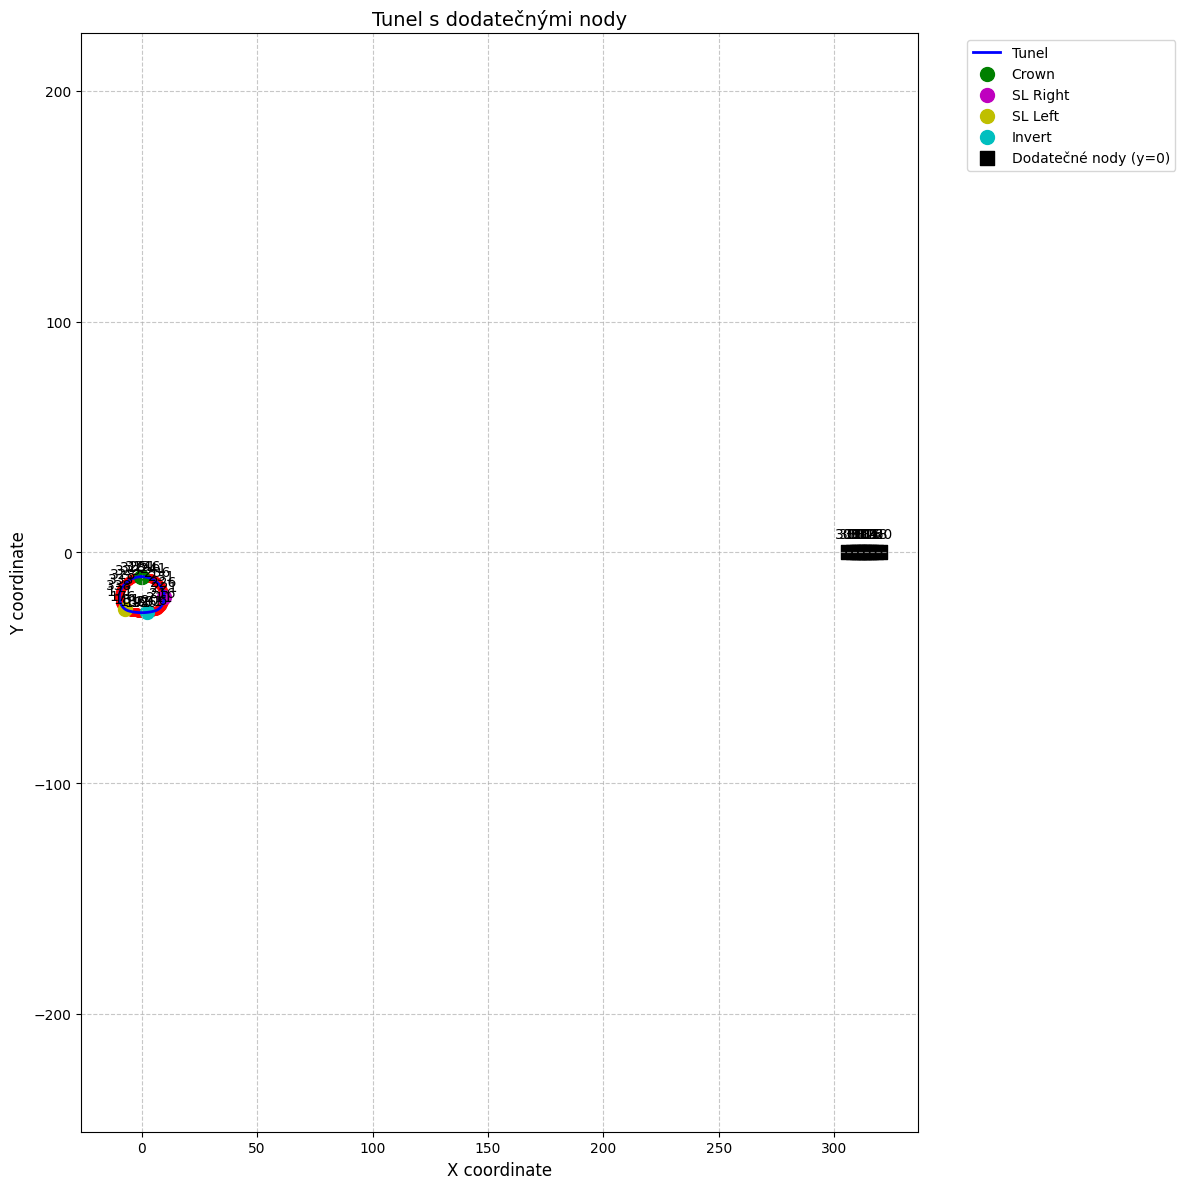

In [11]:
import matplotlib.pyplot as plt


# Dodatečné nody
additional_nodes = [
    (320, 0), (318, 0), (316, 0), (315, 0), 
    (314, 0), (313, 0), (312, 0), (311, 0),
    (310, 0), (308, 0), (306, 0)
]

x_tunnel = [point[0] for point in nodes]
y_tunnel = [point[1] for point in nodes]
x_add = [point[0] for point in additional_nodes]
y_add = [point[1] for point in additional_nodes]


plt.figure(figsize=(12, 12))

# 1. Tunel
plt.plot(x_tunnel, y_tunnel, 'b-', linewidth=2, label='Tunel')
plt.scatter(x_tunnel, y_tunnel, c='r', s=30)

# 2. dodatečné body 
crown_nodes = [nodes[0], nodes[-1]]
sl_right = nodes[29]
sl_left = nodes[72]
invert = nodes[52]

plt.scatter([p[0] for p in crown_nodes], [p[1] for p in crown_nodes], 
            c='g', s=100, label='Crown')
plt.scatter(sl_right[0], sl_right[1], c='m', s=100, label='SL Right')
plt.scatter(sl_left[0], sl_left[1], c='y', s=100, label='SL Left')
plt.scatter(invert[0], invert[1], c='c', s=100, label='Invert')

plt.scatter(x_add, y_add, c='black', s=100, marker='s', label='Dodatečné nody (y=0)')

for i, (xi, yi) in enumerate(nodes):
    if i % 5 == 0: 
        plt.annotate(str(251-i if i <= 83 else 251-i+172), 
                    (xi, yi), 
                    textcoords="offset points", 
                    xytext=(0,5), 
                    ha='center')
for xi, yi in additional_nodes:
    plt.annotate(str(xi), (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.title('Tunel s dodatečnými nody', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

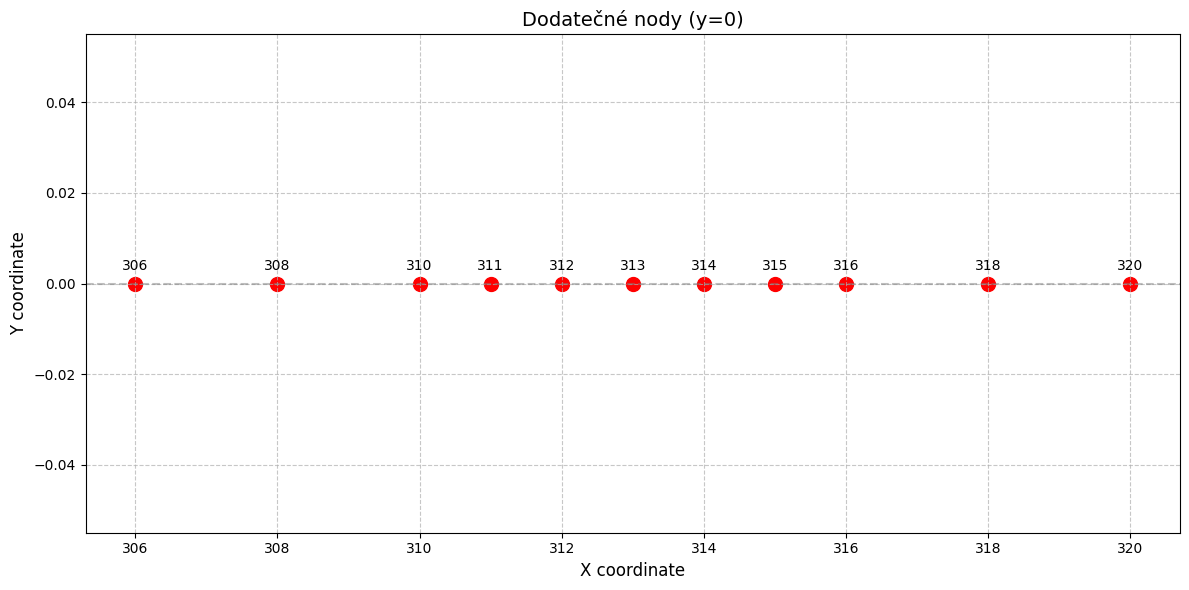

In [13]:
# Pouze samotné nody
x = [point[0] for point in additional_nodes]
y = [point[1] for point in additional_nodes]
labels = [str(point[0]) for point in additional_nodes]

plt.figure(figsize=(12, 6))
plt.scatter(x, y, c='red', s=100, marker='o')


for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10)

# Formátování grafu
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)  # Vodorovná osa
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.title('Dodatečné nody (y=0)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

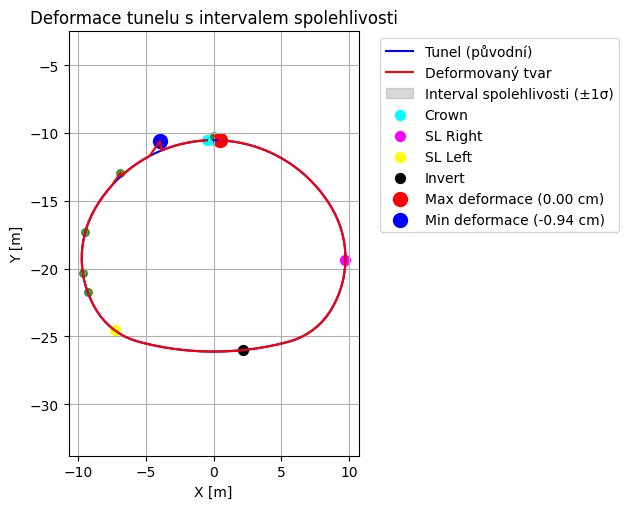

In [44]:

nodes_array = np.array(nodes)
x = nodes_array[:, 0]
y = nodes_array[:, 1]

# Vytvoření plot_nodes v požadovaném formátu [element_no, x, y]
plot_nodes = np.column_stack([np.arange(len(nodes)), x, y])


node_numbers = [
    251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240,
    20, 225, 224, 223, 222, 221, 220, 219, 218, 22, 217, 216,
    215, 214, 213, 212, 211, 210, 209, 208, 207, 17, 192, 191,
    190, 19, 189, 188, 187, 186, 185, 184, 183, 18, 182, 181,
    180, 8, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77,
    76, 75, 7, 391, 392, 393, 31, 394, 395, 396, 397, 398, 399,
    400, 32, 401, 402, 403, 26, 296, 295, 294, 293, 292, 291,
    290, 289, 288, 287, 286, 25, 285, 284, 283, 282, 281, 280,
    279, 278, 23, 262, 261, 260, 259, 258, 257, 256, 255, 254,
    253, 252
]

node_index_map = {num: idx for idx, num in enumerate(node_numbers)}

# Data serazena priklad
u_data = {
    'U_251_1': (251, 5.000000e-07, 0.000016),
    'U_260_1': (260, 2.467500e-03, 0.000147),
    'U_281_1': (281, -3.076528e-03, 0.000980),
    'U_289_1': (289, -9.189029e-03, 0.000799),
    'U_295_1': (295, -4.458262e-03, 0.000987),
    'U_403_1': (403, -6.868428e-03, 0.000839),
    'U_251_2': (251, -3.403418e-03, 0.000698),
    'U_260_2': (260, -9.407883e-03, 0.000625),
    'U_281_2': (281, -6.658691e-03, 0.000491),
    'U_289_2': (289, -7.569670e-04, 0.000383),
    'U_295_2': (295, -1.591071e-04, 0.000368),
    'U_403_2': (403, -5.233238e-04, 0.000522),
    'U_320_19.2': (320, -1.483678e-04, 0.000240),
    'U_318_19.2': (318, -3.327207e-03, 0.000268),
    'U_316_19.2': (316, -1.063502e-02, 0.000569),
    'U_315_19.2': (315, -1.631684e-02, 0.000817),
    'U_314_19.2': (314, -2.397821e-02, 0.001229),
    'U_313_19.2': (313, -2.804680e-02, 0.001390),
    'U_312_19.2': (312, -2.470683e-02, 0.001137),
    'U_311_19.2': (311, -1.805523e-02, 0.000743),
    'U_310_19.2': (310, -1.164303e-02, 0.000492),
    'U_308_19.2': (308, -3.512269e-03, 0.000245),
    'U_306_19.2': (306, -2.900055e-04, 0.000252)
}

# Initialize deformation arrays
Fmultiplier = np.zeros(len(nodes))
std_Fmultiplier = np.zeros(len(nodes))

# Assign deformations to the correct nodes
for u_name, (node_num, mean, std) in u_data.items():
    if node_num in node_index_map:
        idx = node_index_map[node_num]
        Fmultiplier[idx] = mean
        std_Fmultiplier[idx] = std

# Convert to cm
Fmultiplier *= 100
std_Fmultiplier *= 100

# Výpočet deformovaného tvaru
axialF_plot = np.zeros((len(plot_nodes), 2))
for i in range(len(plot_nodes)):
    radius = np.sqrt(plot_nodes[i, 1]**2 + plot_nodes[i, 2]**2)
    if radius > 0:  # Avoid division by zero
        axialF_plot[i, 0] = plot_nodes[i, 1] + (Fmultiplier[i] * plot_nodes[i, 1]) / radius
        axialF_plot[i, 1] = plot_nodes[i, 2] + (Fmultiplier[i] * plot_nodes[i, 2]) / radius
    else:
        axialF_plot[i] = plot_nodes[i, 1:3]

# Výpočet intervalu spolehlivosti
std_mult = 1
lower_quantile_multiplier = Fmultiplier - std_mult * std_Fmultiplier
upper_quantile_multiplier = Fmultiplier + std_mult * std_Fmultiplier

axialF_lower = np.zeros((len(plot_nodes), 2))
axialF_upper = np.zeros((len(plot_nodes), 2))
for i in range(len(plot_nodes)):
    radius = np.sqrt(plot_nodes[i, 1]**2 + plot_nodes[i, 2]**2)
    if radius > 0:
        axialF_lower[i, 0] = plot_nodes[i, 1] + (lower_quantile_multiplier[i] * plot_nodes[i, 1]) / radius
        axialF_lower[i, 1] = plot_nodes[i, 2] + (lower_quantile_multiplier[i] * plot_nodes[i, 2]) / radius
        
        axialF_upper[i, 0] = plot_nodes[i, 1] + (upper_quantile_multiplier[i] * plot_nodes[i, 1]) / radius
        axialF_upper[i, 1] = plot_nodes[i, 2] + (upper_quantile_multiplier[i] * plot_nodes[i, 2]) / radius
    else:
        axialF_lower[i] = plot_nodes[i, 1:3]
        axialF_upper[i] = plot_nodes[i, 1:3]

# Vizualizace
plt.figure(figsize=(16.5 / 2.54, 5.2))
plt.plot(plot_nodes[:, 1], plot_nodes[:, 2], 'b-', label='Tunel (původní)')
plt.plot(axialF_plot[:, 0], axialF_plot[:, 1], 'r-', label='Deformovaný tvar')
plt.fill_betweenx(axialF_plot[:, 1], axialF_lower[:, 0], axialF_upper[:, 0], 
                 color='gray', alpha=0.3, label='Interval spolehlivosti (±1σ)')

# Označení speciálních bodů
crown_nodes = [nodes[0], nodes[-1]]
sl_right = nodes[29]
sl_left = nodes[72]
invert = nodes[52]

plt.scatter([p[0] for p in crown_nodes], [p[1] for p in crown_nodes], c='cyan', s=50, label='Crown')
plt.scatter(sl_right[0], sl_right[1], c='magenta', s=50, label='SL Right')
plt.scatter(sl_left[0], sl_left[1], c='yellow', s=50, label='SL Left')
plt.scatter(invert[0], invert[1], c='black', s=50, label='Invert')

# Označení bodů s deformacemi
deformed_nodes = [node_index_map[node_num] for node_num in node_index_map if Fmultiplier[node_index_map[node_num]] != 0]
for idx in deformed_nodes:
    plt.scatter(axialF_plot[idx, 0], axialF_plot[idx, 1], c='green', s=30, alpha=0.7)

# Označení maximálních a minimálních deformací
max_idx = np.argmax(Fmultiplier)
min_idx = np.argmin(Fmultiplier)
plt.scatter(axialF_plot[max_idx, 0], axialF_plot[max_idx, 1], c='red', s=100, 
            label=f'Max deformace ({Fmultiplier[max_idx]:.2f} cm)')
plt.scatter(axialF_plot[min_idx, 0], axialF_plot[min_idx, 1], c='blue', s=100, 
            label=f'Min deformace ({Fmultiplier[min_idx]:.2f} cm)')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Deformace tunelu s intervalem spolehlivosti')
plt.grid(True)
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

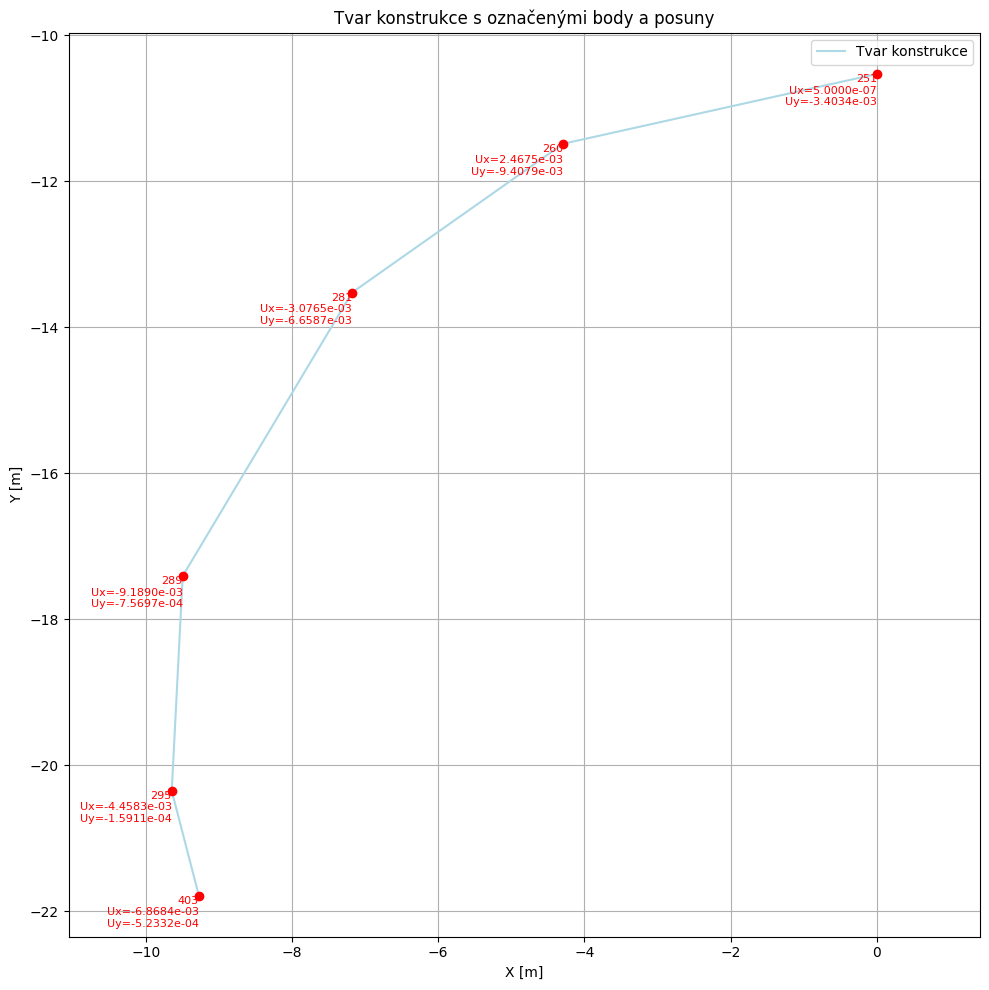

In [40]:

# Zkouška 2
points = {
    251: (0, -10.5275),
    260: (-4.29059, -11.4844),
    281: (-7.17776, -13.5229),
    289: (-9.49344, -17.4055),
    295: (-9.64331, -20.3488),
    403: (-9.27246, -21.7842),
}

displacements = {
    251: (5.000000e-07, -3.403418e-03),
    260: (2.467500e-03, -9.407883e-03),
    281: (-3.076528e-03, -6.658691e-03),
    289: (-9.189029e-03, -7.569670e-04),
    295: (-4.458262e-03, -1.591071e-04),
    403: (-6.868428e-03, -5.233238e-04),
}

x = [pt[0] for pt in points.values()]
y = [pt[1] for pt in points.values()]

plt.figure(figsize=(10, 10))
plt.plot(x, y, '-', label='Tvar konstrukce', color='lightblue')

node_counts = Counter()
for node_id in displacements:
    node_counts[node_id] += 1

# Vykreslení posunů
for node_id, (ux, uy) in displacements.items():
    px, py = points[node_id]
    color = 'green' if node_counts[node_id] > 1 else 'red'
    plt.plot(px, py, 'o', color=color)
    plt.text(px, py, f'{node_id}\nUx={ux:.4e}\nUy={uy:.4e}',
             fontsize=8, ha='right', va='top', color=color)

plt.axis('equal')
plt.grid(True)
plt.title('Tvar konstrukce s označenými body a posuny')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend()
plt.tight_layout()
plt.show()
